In [1]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

path = os.getcwd()
sys.path.append(path + '/../modules')

from Basilisk import __path__
from Basilisk.architecture import messaging
from Basilisk.fswAlgorithms import attTrackingError
from Basilisk.fswAlgorithms import inertial3D
from Basilisk.fswAlgorithms import mrpFeedback
from Basilisk.fswAlgorithms import rwMotorTorque
import sun_repulse_control

from Basilisk.simulation import boreAngCalc
from Basilisk.simulation import reactionWheelStateEffector
from Basilisk.simulation import simpleNav
from Basilisk.simulation import spacecraft

from Basilisk.utilities import macros
from Basilisk.utilities import orbitalMotion
from Basilisk.utilities import RigidBodyKinematics as rbk
from Basilisk.utilities import simIncludeGravBody
from Basilisk.utilities import simIncludeRW
from Basilisk.utilities import SimulationBaseClass
from Basilisk.utilities import unitTestSupport
from Basilisk.utilities import vizSupport

bskPath = __path__[0]
fileName = os.path.basename(os.path.splitext(os.path.abspath(''))[0])

In [2]:
# Plotting RW functions
def plot_attitude_error(timeData, dataSigmaBR):
    """Plot the attitude errors."""
    plt.figure(1)
    for idx in range(3):
        plt.plot(timeData, dataSigmaBR[:, idx],
                 color=unitTestSupport.getLineColor(idx, 3),
                 label=r'$\sigma_' + str(idx) + '$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [min]')
    plt.ylabel(r'Attitude Error $\sigma_{B/R}$')

def plot_rw_cmd_torque(timeData, dataUsReq, numRW):
    """Plot the RW command torques."""
    plt.figure(2)
    for idx in range(3):
        plt.plot(timeData, dataUsReq[:, idx],
                 '--',
                 color=unitTestSupport.getLineColor(idx, numRW),
                 label=r'$\hat u_{s,' + str(idx) + '}$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [min]')
    plt.ylabel('RW Motor Torque [Nm]')

def plot_rw_motor_torque(timeData, dataUsReq, dataRW, numRW):
    """Plot the RW actual motor torques."""
    plt.figure(2)
    for idx in range(3):
        plt.plot(timeData, dataUsReq[:, idx],
                 '--',
                 color=unitTestSupport.getLineColor(idx, numRW),
                 label=r'$\hat u_{s,' + str(idx) + '}$')
        plt.plot(timeData, dataRW[idx],
                 color=unitTestSupport.getLineColor(idx, numRW),
                 label='$u_{s,' + str(idx) + '}$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [min]')
    plt.ylabel('RW Motor Torque [Nm]')

def plot_rate_error(timeData, dataOmegaBR):
    """Plot the body angular velocity rate tracking errors."""
    plt.figure(3)
    for idx in range(3):
        plt.plot(timeData, dataOmegaBR[:, idx],
                 color=unitTestSupport.getLineColor(idx, 3),
                 label=r'$\omega_{BR,' + str(idx) + '}$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [min]')
    plt.ylabel('Rate Tracking Error [rad/s]')

def plot_rw_speeds(timeData, dataOmegaRW, numRW):
    """Plot the RW spin rates."""
    plt.figure(4)
    for idx in range(numRW):
        plt.plot(timeData, dataOmegaRW[:, idx] / macros.RPM,
                 color=unitTestSupport.getLineColor(idx, numRW),
                 label=r'$\Omega_{' + str(idx) + '}$')
    plt.legend(loc='lower right')
    plt.xlabel('Time [min]')
    plt.ylabel('RW Speed [RPM]')

def plot_repulse_axis_miss_angle(timeData, dataMissAngle, exclusion_angle):
    """Plot the miss angle between the repulse axis and Sun."""
    fig, ax = plt.subplots()
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    exclusion_angle_degrees = np.ones(len(timeData)) * exclusion_angle * macros.R2D
    plt.plot(timeData, exclusion_angle_degrees, '--', color = 'r', label = r'exclusion angle')

    data = list(map(lambda d: d*macros.R2D, dataMissAngle))
    for idx in range(len(data)):
        plt.plot(timeData, data[idx], color=unitTestSupport.getLineColor(idx, 3))
    
    plt.legend(loc='lower right')
    plt.xlabel('Time [min]')
    plt.ylabel('Sun avoidance angle [deg]')

# Setup the simulation tasks 

In [3]:
# Create simulation variable names
task_name = "simTask"
process_name = "simProcess"

# Create a sim module as an empty container
simulation = SimulationBaseClass.SimBaseClass()

simulation.SetProgressBar(False)

# create the simulation process
process = simulation.CreateNewProcess(process_name)

# create the dynamics task and specify the simulation time and integration update time
simulation_duration = macros.min2nano(1.5)
task_update_rate = macros.sec2nano(0.1)
process.addTask(simulation.CreateNewTask(task_name, task_update_rate))

In [4]:
# initialize spacecraft object and set properties
spacecraft = spacecraft.Spacecraft()
spacecraft.ModelTag = "Bevo2-Sat"

# add spacecraft object to the simulation process
simulation.AddModelToTask(task_name, spacecraft, 1)

# setup Gravity Body
gravity_factory = simIncludeGravBody.gravBodyFactory()

# Next a series of gravitational bodies are included
gravity_bodies = gravity_factory.createBodies(['earth', 'sun'])
earth = gravity_bodies['earth']
earth.isCentralBody = True
mu = earth.mu

# The configured gravitational bodies are added to the spacecraft dynamics with the usual command:
gravity_factory.addBodiesTo(spacecraft)

# Next, the default SPICE support module is created and configured.
initial_time_string = "2021 JANUARY 15 00:28:30.0"

# The following is a support macro that creates a `spiceObject` instance
spice_module = gravity_factory.createSpiceInterface(time=initial_time_string, epochInMsg=True)

# Earth is gravity center
spice_module.zeroBase = 'Earth'

# The SPICE object is added to the simulation task list.
simulation.AddModelToTask(task_name, gravity_factory.spiceObject, 2)

# The gravitational body is connected to the spacecraft object
gravity_factory.addBodiesTo(spacecraft)

# setup the orbit using classical orbit elements
oe = orbitalMotion.ClassicElements()
oe.a = 7000. * 1000      # meters
oe.e = 0.0001
oe.i = 33.3 * macros.D2R
oe.Omega = 148.2 * macros.D2R
oe.omega = 347.8 * macros.D2R
oe.f = 135 * macros.D2R
rN, vN = orbitalMotion.elem2rv(mu, oe)

# To set the spacecraft initial conditions, the following initial position and velocity variables are set:
spacecraft.hub.r_CN_NInit = rN  # m   - r_BN_N
spacecraft.hub.v_CN_NInit = vN  # m/s - v_BN_N
spacecraft.hub.sigma_BNInit = [0.0, 0.0, 0.2]  # MRP set to customize initial inertial attitude
spacecraft.hub.omega_BN_BInit = [[0.0], [-0.01], [0.0]]             # rad/s - omega_CN_B
# scObject.hub.sigma_BNInit = rbk.C2MRP(np.array([[0, 1, 0],[0,0,1],[1,0,0]]).T)

# define the simulation inertia
I = [0.02 / 3,  0.,         0.,
     0.,        0.1256 / 3, 0.,
     0.,        0.,         0.1256 / 3]
spacecraft.hub.mHub = 4.0  # kg - spacecraft mass
spacecraft.hub.r_BcB_B = [[0.0], [0.0], [0.0]]  # m - position vector of body-fixed point B relative to CM
spacecraft.hub.IHubPntBc_B = unitTestSupport.np2EigenMatrix3d(I)

#
# add RW devices
# Make RW factory instance
rw_factory = simIncludeRW.rwFactory()

# store the RW dynamical model type
wheel_balance_type = messaging.BalancedWheels

# create each RW by specifying the RW type, the spin axis gsHat, plus optional arguments
maxMomentum = 0.01
maxSpeed = 6000 * macros.RPM
RW1 = rw_factory.create('custom', [1, 0, 0], Omega=0.  # RPM
                       , Omega_max=maxSpeed
                       , maxMomentum=maxMomentum
                       , u_max=0.005
                       , RWModel=wheel_balance_type)
RW2 = rw_factory.create('custom', [0, 1, 0], Omega=0.  # RPM
                       , Omega_max=maxSpeed
                       , maxMomentum=maxMomentum
                       , u_max=0.005
                       , RWModel=wheel_balance_type)
RW3 = rw_factory.create('custom', [0, 0, 1], Omega=0.  # RPM
                       , Omega_max=maxSpeed
                       , maxMomentum=maxMomentum
                       , u_max=0.005
                       , RWModel=wheel_balance_type)

num_rw = rw_factory.getNumOfDevices()

# create RW object container and tie to spacecraft object
rw_state_effector = reactionWheelStateEffector.ReactionWheelStateEffector()
rw_state_effector.ModelTag = "RW_cluster"
rw_factory.addToSpacecraft(spacecraft.ModelTag, rw_state_effector, spacecraft)

# add RW object array to the simulation process
simulation.AddModelToTask(task_name, rw_state_effector, 2)

# add the simple Navigation sensor module
simple_nav = simpleNav.SimpleNav()
simple_nav.ModelTag = "SimpleNavigation"
simulation.AddModelToTask(task_name, simple_nav)

#
#   setup the FSW algorithm tasks
#                  

# setup readManeuver guidance module
inertial_point = inertial3D.inertial3D()
inertial_point.ModelTag = "inertial3DPoint"
inertial_point.sigma_R0N = [0, 0, 1]
# inertialPoint.sigma_R0N = rbk.C2MRP(np.array([[0, 0, 0],[0, 0, -1],[1,0,0]]).T)
simulation.AddModelToTask(task_name, inertial_point)

# setup the attitude tracking error evaluation module
attitude_error = attTrackingError.attTrackingError()
attitude_error.ModelTag = "attErrorInertial3D"
simulation.AddModelToTask(task_name, attitude_error)

# setup the MRP Feedback control module
mrp_control = mrpFeedback.mrpFeedback()
mrp_control.ModelTag = "mrpFeedback"
simulation.AddModelToTask(task_name, mrp_control)
decay_time = 10.0
xi = 1.0
mrp_control.Ki = -1  # make value negative to turn off integral feedback
mrp_control.P = 3*np.max(I)/decay_time
mrp_control.K = (mrp_control.P/xi)*(mrp_control.P/xi)/np.max(I)
# mrpControl.integralLimit = 2. / mrpControl.Ki * 0.1

# setup sun repulse control module
sun_repulse = sun_repulse_control.SunRepulse()
sun_repulse.ModelTag = "sunRepulse"
sun_repulse.angle_min = 55.0 * np.pi/180
sun_repulse.sHat_B_avoid = np.array([-1.0, 0.0, 0.0])
sun_repulse.K_proportional_gain = 1.0
simulation.AddModelToTask(task_name, sun_repulse)

# add module that maps the Lr control torque into the RW motor torques
rw_motor_torque = rwMotorTorque.rwMotorTorque()
rw_motor_torque.ModelTag = "rwMotorTorque"
simulation.AddModelToTask(task_name, rw_motor_torque)

# Make the RW control all three body axes
controlAxes_B = [1, 0, 0, 0, 1, 0, 0, 0, 1]
rw_motor_torque.controlAxes_B = controlAxes_B

repulse_bore_angle = boreAngCalc.BoreAngCalc()
repulse_bore_angle.ModelTag = "sun_repulse_boresight"
repulse_bore_angle.boreVec_B = sun_repulse.sHat_B_avoid  # boresight in body frame
simulation.AddModelToTask(task_name, repulse_bore_angle)

#
#   Setup data logging before the simulation is initialized
#
simple_nav_recorder = simple_nav.attOutMsg.recorder(task_update_rate)
simulation.AddModelToTask(task_name, simple_nav_recorder)

sc_state_recorder = spacecraft.scStateOutMsg.recorder(task_update_rate)
simulation.AddModelToTask(task_name, sc_state_recorder)

rw_motor_recorder = rw_motor_torque.rwMotorTorqueOutMsg.recorder(task_update_rate)
simulation.AddModelToTask(task_name, rw_motor_recorder)

attitude_error_recorder = attitude_error.attGuidOutMsg.recorder(task_update_rate)
simulation.AddModelToTask(task_name, attitude_error_recorder)

repulse_bore_angle_recorder = repulse_bore_angle.angOutMsg.recorder(task_update_rate)
simulation.AddModelToTask(task_name, repulse_bore_angle_recorder)

rw_speed_recorder = rw_state_effector.rwSpeedOutMsg.recorder(task_update_rate)
simulation.AddModelToTask(task_name, rw_speed_recorder)

# A message is created that stores an array of the Omega wheel speeds
rw_recorder = []
for item in range(num_rw):
    rw_recorder.append(rw_state_effector.rwOutMsgs[item].recorder(task_update_rate))
    simulation.AddModelToTask(task_name, rw_recorder[item])

In [5]:
# create the FSW vehicle configuration message
vehicle_config_out = messaging.VehicleConfigMsgPayload()
vehicle_config_out.ISCPntB_B = I  # use the same inertia in the FSW algorithm as in the simulation
vc_msg = messaging.VehicleConfigMsg().write(vehicle_config_out)

# Setup the FSW RW configuration message.
fsw_rw_parameters_msg = rw_factory.getConfigMessage()

# link messages
simple_nav.sunStateInMsg.subscribeTo(gravity_factory.spiceObject.planetStateOutMsgs[1])
simple_nav.scStateInMsg.subscribeTo(spacecraft.scStateOutMsg)
attitude_error.attNavInMsg.subscribeTo(simple_nav.attOutMsg)
attitude_error.attRefInMsg.subscribeTo(inertial_point.attRefOutMsg)
mrp_control.guidInMsg.subscribeTo(attitude_error.attGuidOutMsg)
mrp_control.vehConfigInMsg.subscribeTo(vc_msg)
mrp_control.rwParamsInMsg.subscribeTo(fsw_rw_parameters_msg)
mrp_control.rwSpeedsInMsg.subscribeTo(rw_state_effector.rwSpeedOutMsg)
sun_repulse.base_torque_in_msg.subscribeTo(mrp_control.cmdTorqueOutMsg)
sun_repulse.navigation_in_msg.subscribeTo(simple_nav.attOutMsg)
rw_motor_torque.rwParamsInMsg.subscribeTo(fsw_rw_parameters_msg)
rw_motor_torque.vehControlInMsg.subscribeTo(sun_repulse.attitude_torque_out_msg)
# rwMotorTorque.vehControlInMsg.subscribeTo(mrpControl.cmdTorqueOutMsg)
rw_state_effector.rwMotorCmdInMsg.subscribeTo(rw_motor_torque.rwMotorTorqueOutMsg)

# Boresight modules
repulse_bore_angle.scStateInMsg.subscribeTo(spacecraft.scStateOutMsg)
repulse_bore_angle.celBodyInMsg.subscribeTo(spice_module.planetStateOutMsgs[1])

simulation.InitializeSimulation()

# configure a simulation stop time and execute the simulation run
simulation.ConfigureStopTime(simulation_duration)
simulation.ExecuteSimulation()

# Retrieve the logged data and recorder messages

In [6]:
data_motor_torque_requested = rw_motor_recorder.motorTorque
data_sigma_BR = attitude_error_recorder.sigma_BR
data_omega_BR = attitude_error_recorder.omega_BR_B
data_omega_rw = rw_speed_recorder.wheelSpeeds
data_vehicle_to_sun_B = simple_nav_recorder.vehSunPntBdy
# print(dataVehSunPntBdy)
# dataSTMissAngle = stBACOLog.missAngle
repulse_sun_angle = repulse_bore_angle_recorder.missAngle

data_rw = []
for i in range(num_rw):
    data_rw.append(rw_recorder[i].u_current)

np.set_printoptions(precision=16)

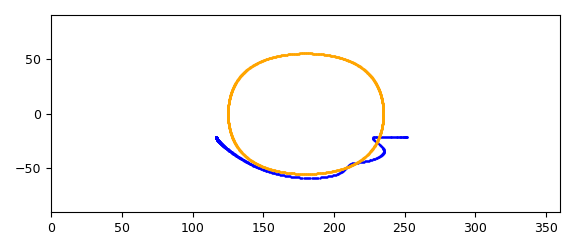

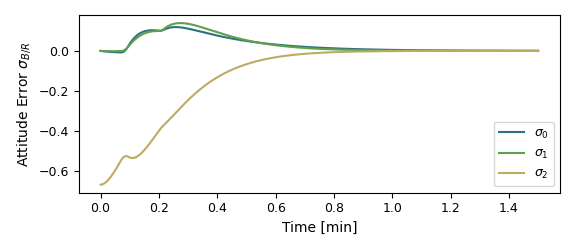

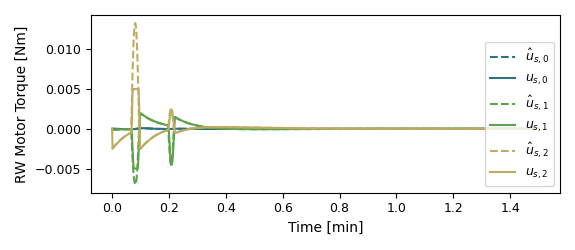

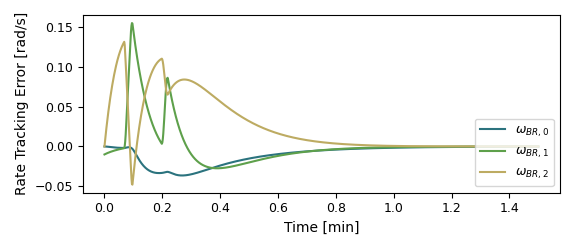

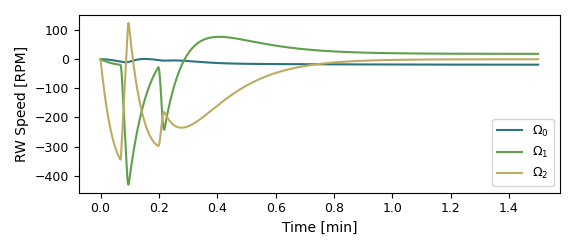

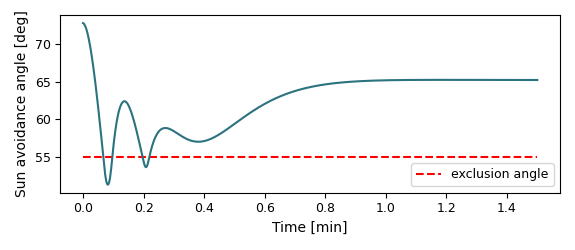

In [7]:
time_series = rw_motor_recorder.times() * macros.NANO2MIN
%matplotlib widget
plot_attitude_error(time_series, data_sigma_BR)
plot_rw_motor_torque(time_series, data_motor_torque_requested, data_rw, num_rw)
plot_rate_error(time_series, data_omega_BR)
plot_rw_speeds(time_series, data_omega_rw, num_rw)
plot_repulse_axis_miss_angle(time_series, [repulse_sun_angle], sun_repulse.angle_min)


def vector_2_ra_dec(v_N):
    v = v_N/np.linalg.norm(v_N)
    dec = np.arcsin(v[2]) * 180. / np.pi
    if v[1] > 0:
        ra = np.arccos(v[0] / np.cos(np.arcsin(v[2]))) * 180 / np.pi
    else:
        ra = 360 - np.arccos(v[0] / np.cos(np.arcsin(v[2]))) * 180 / np.pi
    return ra, dec


def getCone(v, fov, mesh=360 * 5):
    v /= np.linalg.norm(v)
    b2 = np.array([0., 1., 0.])
    b3 = np.array([0., 0., 1.])
    b = np.copy(b3)
    if np.dot(v, b3) < 1E-1:
        b = np.copy(b2)
    z = np.cross(v, b) / np.linalg.norm(np.cross(v, b))

    ROT = rbk.PRV2C(np.deg2rad(fov) * z)
    c1 = np.dot(ROT, v)
    Raz = []
    Decz = []
    for i in np.linspace(0, 359.75, int(mesh)):
        ROTCone = rbk.PRV2C(np.deg2rad(i) * v)
        ra, Dec = vector_2_ra_dec(np.dot(ROTCone, c1))
        Raz.append(ra)
        Decz.append(Dec)
    return Raz, Decz

result = np.array(list(map(lambda vec: vector_2_ra_dec(vec), data_vehicle_to_sun_B)))
[keep_out_ra, keep_out_dec] = getCone(sun_repulse.sHat_B_avoid, sun_repulse.angle_min*180/np.pi)

plt.figure(6)
# plt.plot(result[:,0], result[:,1])
plt.scatter(result[:,0], result[:,1], marker=".", color="blue", s=2)
plt.scatter(keep_out_ra, keep_out_dec, marker=".", color="orange", s=1)
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.show()